<a href="https://colab.research.google.com/github/harimshin/data-science-portfolio/blob/main/monitoring_plan_pima_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MLOps / Model Risk Management - Monitoring Plan - Gradient Boosting Model for Pima Diabetes.ipynb**

# **Data**


* **Data source:** the National Institute of Diabetes and Digestive and Kidney Diseases
* **Data objective:** to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset
* **Sample characteristics:** all patients here here are females at least 21 years old of Pima heritage.
* **Variables**:
  * Target:
    * `Outcome` Class variable (0 or 1) / Whether a patient is diabetic (`Outcome = 1`) or non-diabetic (`Outcome = 0`)
  * Features:
    * `Pregnancies`: Number of times pregnant
    * `Glucose`: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
    * `BloodPressure`: Diastolic blood pressure (mm Hg)
    * `SkinThickness`: Triceps skin fold thickness (mm)
    * `Insulin`: 2-Hour serum insulin (mu U/ml)
    * `BMI`: Body mass index (weight in kg/(height in m)^2)
    * `DiabetesPedigreeFunction`: Diabetes pedigree function
    * `Age`: Age (years)



**Data preparation**

In [1]:
import pandas as pd

column_names = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
]
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv', names=column_names)

In [2]:
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [3]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# **Model**

**Gradient Boosting with Hyperparameter Tuning**

In [4]:
pip install scikit-learn

In [5]:
from sklearn.model_selection import train_test_split

# Select features and target variable
X = df.drop("Outcome", axis=1)
y = df["Outcome"]
print(X.shape, y.shape)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(768, 8) (768,)


In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Initialize the Gradient Boosting model
gb = GradientBoostingClassifier()

# Initialize GridSearchCV
gb_cv = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model to the training data using GridSearchCV
gb_cv_model = gb_cv.fit(X_train, y_train)

# Get the best parameters and best model
best_params = gb_cv_model.best_params_
best_model = gb_cv_model.best_estimator_

# Make predictions on the test set using the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)

# Print the results
print("Best Parameters:", best_params)
print(f"Best Model Accuracy: {accuracy_best}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best Model Accuracy: 0.7662337662337663


**Featue Impotance**

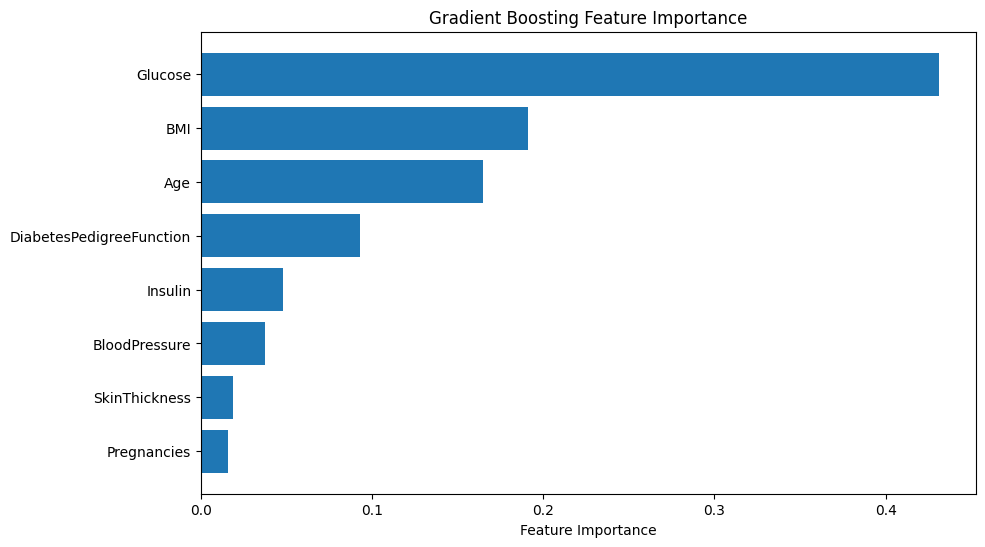

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(X.shape[1]), feature_importance[sorted_idx], align='center')
plt.yticks(range(X.shape[1]), X.columns[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Gradient Boosting Feature Importance")
plt.show()

# **1. Conceptual Soundness**

1-1. Model design (Gradient Boosting Specific)

a. Non-linearity: It is known that gradient boosting outperforms other binary classification models when the features are non-linearly related.

a-1. **Ramsey's RESET Test** (Regression Equation Specification Error Test): This is a formal test to check for model misspecification, including omitted nonlinearity. It tests whether higher-order terms (squares or cubes) of the predicted values add significant explanatory power.

In [8]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset

model = sm.OLS(y, X).fit()
reset_test = linear_reset(model, power=2)
print("p-value: "+ str(reset_test.pvalue))

p-value: 3.8404106115889474e-10


Since p-value of Ramsey's RESET test is less than 0.05, we can conclude that there is a nonlinearity in the model.

a-2. **Locally Weighted Scatterplot Smoothing (LOWESS)**

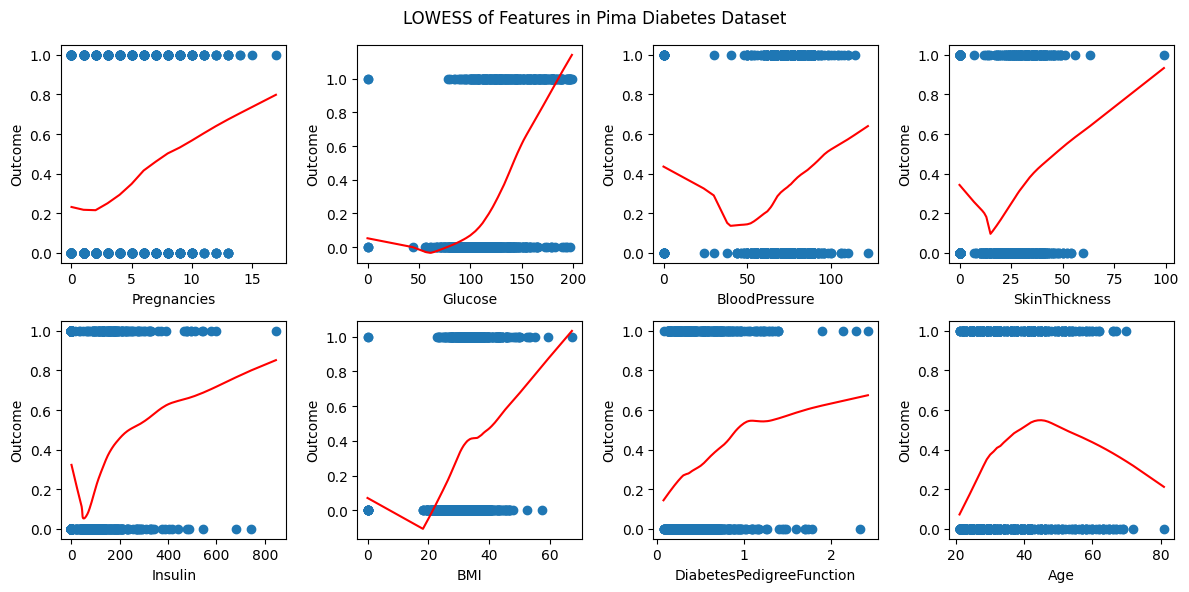

In [9]:
import statsmodels.api as sm

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
axes = axes.flatten()
fig.suptitle('LOWESS of Features in Pima Diabetes Dataset')

for col in X.columns:
    lowess = sm.nonparametric.lowess(y, X[col])
    ax = axes[X.columns.get_loc(col)]
    ax.scatter(X[col], y)
    ax.plot(lowess[:, 0], lowess[:, 1], color='red')
    ax.set_xlabel(col)
    ax.set_ylabel('Outcome')

plt.tight_layout()
plt.show()

The results indicate that there is a nonlinearity between target `Outcome` and features `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`, and `Age`.

b. Outlier: Gradient boosting is resistant to outliers in continuous variables compared to other binary classification models. Box plots show if a data point is significantly differs from the other observation(outlier)


b-1. **Box plots**: This is a visual method to detect outliers. Points outside the whiskers of the box plot are considered potential outliers. The whiskers typically extend to 1.5 times the IQR.

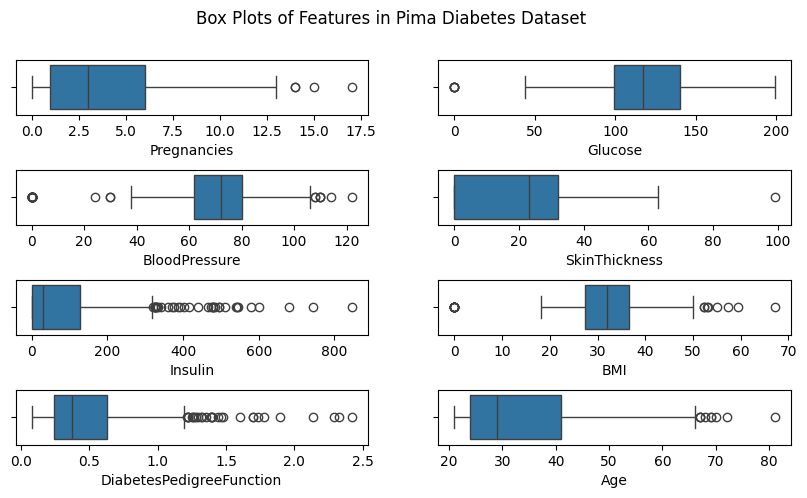

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(4, 2, figsize=(10, 5))
axes = axes.flatten()
fig.suptitle('Box Plots of Features in Pima Diabetes Dataset')

for i in range(len(X.columns)):
  sns.boxplot(data = df, x = X.columns[i], ax = axes[i])
plt.subplots_adjust(hspace=1)
plt.show()

The plots above indicate that `Insulin` and `DiabetesPedigreeFunction` have a lot of upper outliers.

c. Predictability vs. interpretability: Gradient boosting model is known for its strong predictability, but it lacks predictability due to the nature of the model. We should verify if the purpose of the model is to maximize the accuracy of the prediction, not to interpret the results to make an inference.
 Revisit the purpose of the task or research question (no formal test is required)


2-2. Model assumptions: Unlike other binary classification models, gradient boosting does not assume linearity, normality, or independence of features.

a. *Differentiable loss function*: Gradient boosting tries to minimize the loss function, so the loss function should be differentiable.
 * We ran gradient boosting with scikit-learn’s GradientBoostingClassifier library. We do not need to worry about the differentiability of the loss function since the default loss function in the library we are using is logistic loss, which is differentiable (no formal test is required)

b. *Weak learner*: Ensemble methods like gradient boosting creates a strong model by combining multiple weak learners designed to make incremental improvement.
* Depth of the tree should be relatively small for the simplicity of the base model. We keep ‘max_depth’, which is the argument indicating tree depth in GradientBoostingClassifier, between 3 and 7 for grid search. (no formal test is required)Box plots show if a data point is significantly differs from the other observation(outlier)


# **2. Model Implementation & Deployment**



2-1. Model Robustness and Reliability: Sensitivity Analysis
* We first identify the model and decide which input variable will be varied for the analysis. Next, we select analysis method which might be appropriate for the analysis purpose. Then, we observe the changes in the output after varying the inputs according to the selected method. Finally, we can analyze which input variables have the strongest impact on the output and how sensitive the model is to the input change.

a. Local Sensitivity Analysis: **One-at-a-time (OAT)**
* Local sensitivity analysis examines how a small perturbation in one input affects the output while keeping other inputs fixed.

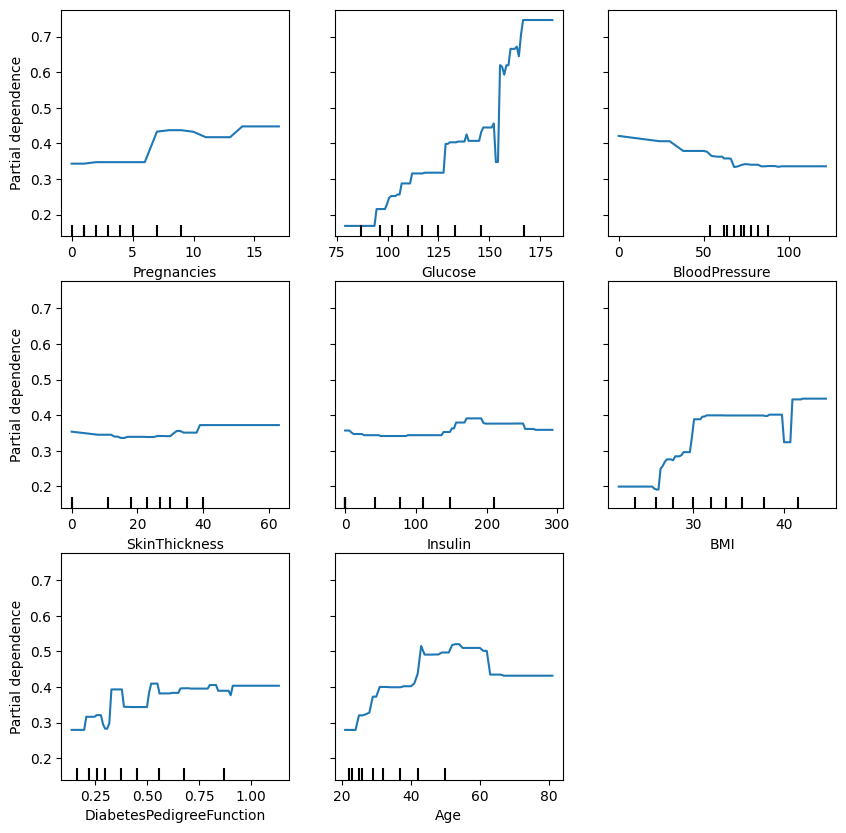

In [11]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(10, 10))
PartialDependenceDisplay.from_estimator(gb_cv_model, X_train, X.columns, ax=ax)
plt.show()

The graphs above show that the featue to which `Outcome` is most sensitive is `Glucose`  when other features are held constant.

b. Global Sensitivity Analysis: **Sobol Analysis** (Variance-based method)
* Global sensitivity analysis examines the sensitivity of the output to input variables across the entire input space, considering interactions between variables and accounting for their potential uncertainty or variability.


In [12]:
pip install SALib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.0 MB/s eta 0:00:00


In [13]:
from SALib.sample import sobol as sobol_sampler
from SALib.analyze import sobol as sobol_analyzer
import numpy as np

problem = {
    'num_vars': X.shape[1],
    'names': X.columns.tolist(),
    'bounds': [[X[col].min(), X[col].max()] for col in X.columns]
}

num_samples = 1024
X_sobol_samples = sobol_sampler.sample(problem = problem, N = num_samples)
y_sobol_samples = gb_cv_model.predict(X_sobol_samples)
sobol_results = sobol_analyzer.analyze(problem, y_sobol_samples)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


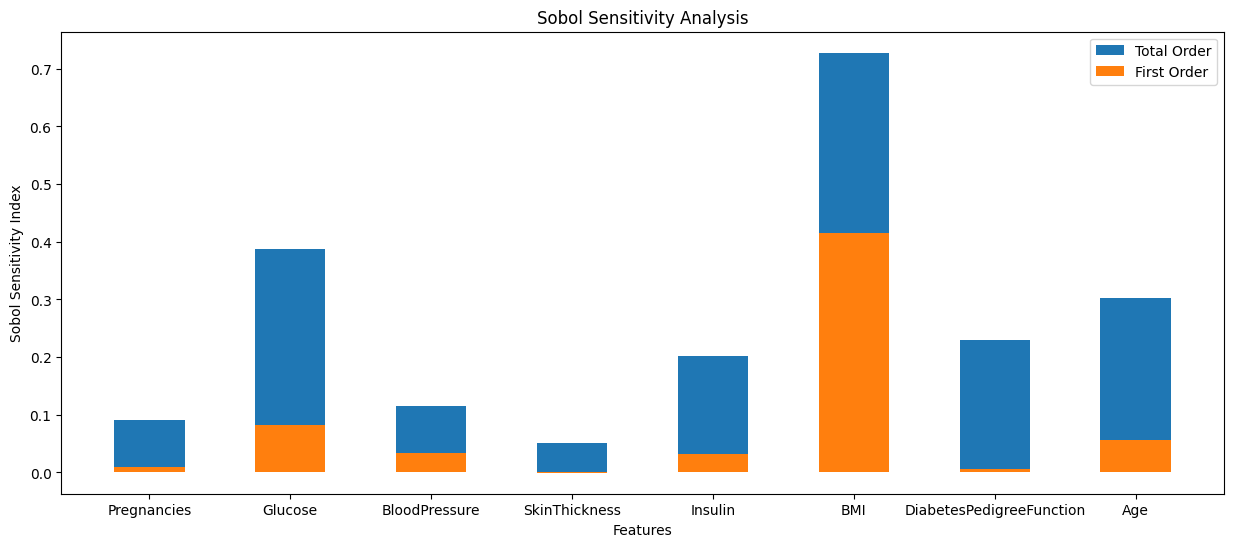

In [14]:
plt.figure(figsize=(15, 6))

plt.bar(x = X.columns, height = sobol_results['ST'], width = 0.5, alpha=1, label="Total Order")
plt.bar(x = X.columns, height = sobol_results['S1'], width = 0.5, alpha=1, label="First Order")

plt.xlabel("Features")
plt.ylabel("Sobol Sensitivity Index")
plt.legend()
plt.title("Sobol Sensitivity Analysis")
plt.show()

Unlike the results of local sensitivity analysis, `BMI` has the greatest total impact on `Outcome` with respect to Sobol sensitivity index when we take account of both direct and indirect effects of variables. `Glucose`, which was verified as the most impactful variable in local sensitivity analysis, did not exceed `BMI` in total, but it shows the greatest amount of indirect effect on `Outcome` in terms of sobol sensitivity index.

2-2. Performance test

a. **Scalability Test**: We test how a system or a model performs when the data size increases to ensure it can handle increased demands. To simulate the situation of data increase, we gradually increase the size of the data by generating synthetic data and test how much resources such as CPU and memory are used and how much time is consumed when running the model.

In [15]:
from psutil import cpu_percent, virtual_memory

cpu_usage = cpu_percent(interval=1)
memory_usage = virtual_memory().percent
print(f"CPU Usage: {cpu_usage}%")
print(f"Memory Usage: {memory_usage}%")

CPU Usage: 6.4%
Memory Usage: 4.1%


b. **Stress test**: We test how a system or a model responses to extreme situations which are beyond normal operating capacity. To simulate this extreme situation, we can push the system to process huge amount of data and see if the system crashes and the performance drops.
* Here, I generate df_new, an arbitrary data set based on the distribution of the original data set using copula. This is *not* the correct way to use copula for data with continuous and discrete variable, but the data generated here will be only used to demonstrate the code for stress testing and data drift.

In [16]:
pip install copulas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 1.5 MB/s eta 0:00:00


In [17]:
from copulas.multivariate import GaussianMultivariate

copula_model = GaussianMultivariate()
copula_model.fit(df)

df_new = copula_model.sample(len(df))
df_new = pd.DataFrame(df_new, columns=df.columns)

threshold = np.percentile(df_new['Outcome'],np.mean(df['Outcome'])*100)
df_new['Outcome'] = df_new['Outcome'].apply(lambda x: 1 if x > threshold else 0)

X_new = df_new.drop(['Outcome'], axis = 1)
y_new = df_new['Outcome']

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from th

In [18]:
import time

# gradually increase the data size and measure the time taken
data_sizes = []

for i in range(10):
  data_sizes.append(pow(10, 3)*(i+1))

for i in range(len(data_sizes)):
  df_add = copula_model.sample(data_sizes[i])
  df_add = pd.DataFrame(df_add, columns=df.columns)
  threshold = np.percentile(df_add['Outcome'],np.mean(df['Outcome'])*100)
  df_add['Outcome'] = df_add['Outcome'].apply(lambda x: 1 if x > threshold else 0)

  start_time = time.time()

  X_add = df_add.drop(['Outcome'], axis=1)
  y_add = df_add['Outcome']
  X_add_train, X_add_test, y_add_train, y_add_test = train_test_split(X_add, y_add, test_size=0.2, random_state=42)
  gb_cv_model.fit(X_add_train, y_add_train)
  best_params = gb_cv_model.best_params_
  best_model = gb_cv_model.best_estimator_
  y_add_pred_best = best_model.predict(X_add_test)

  end_time = time.time()

  execution_time = end_time - start_time

  print(f"Data size: {data_sizes[i]}, Time taken: {execution_time:.2f} seconds")

Data size: 1000, Time taken: 15.36 seconds
Data size: 2000, Time taken: 19.75 seconds
Data size: 3000, Time taken: 30.19 seconds
Data size: 4000, Time taken: 34.36 seconds
Data size: 5000, Time taken: 42.52 seconds
Data size: 6000, Time taken: 48.90 seconds
Data size: 7000, Time taken: 57.13 seconds
Data size: 8000, Time taken: 64.52 seconds
Data size: 9000, Time taken: 71.74 seconds
Data size: 10000, Time taken: 80.04 seconds


# **3. Model Deployment**

3-1. Data Drift: We should check if there is any changes in the statistical distribution of input features over time.


a. **Histogram** visually compares the distribution of old data and new data for each feature

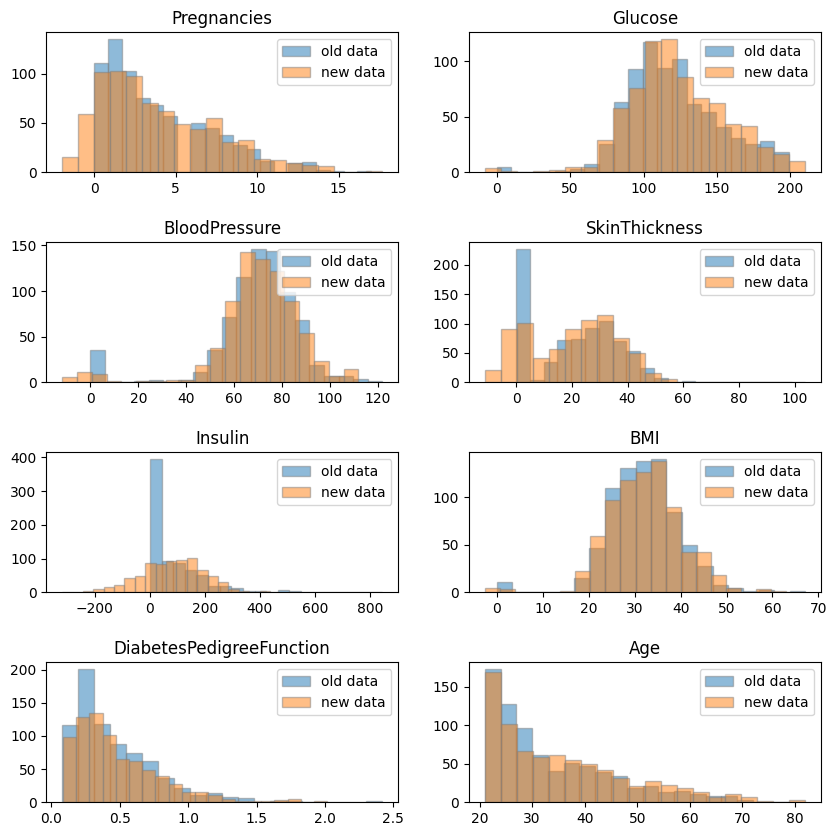

In [19]:
plt.figure(figsize = (10,10))
plt.subplots_adjust(hspace = 0.5)
for i in range(len(X.columns)):
  plt.subplot(4,2,i+1)
  plt.hist(df[X.columns[i]], bins = 20, alpha = 0.5, edgecolor = 'grey', linewidth = 1, label = 'old data')
  plt.hist(df_new[X.columns[i]], bins = 20, alpha = 0.5, edgecolor = 'grey', linewidth = 1, label = 'new data')
  plt.legend(loc='upper right')
  plt.title(X.columns[i])

We can observe the distribution of `Insulin` has been significantly changed.

b. **Kolmogorov-Smirnov test** yields p-values showing if the change in each variable is statistically significant


In [20]:
from scipy.stats import ks_2samp
KS_pvalue = ks_2samp(X, X_new).pvalue

KS_results = {
    'feature': X.columns,
    'p-value': np.round(KS_pvalue, 4),
    'data drift': KS_pvalue < 0.05
}

KS_results_df = pd.DataFrame(KS_results)
print(KS_results_df)

                    feature  p-value  data drift
0               Pregnancies   0.0019        True
1                   Glucose   0.0877       False
2             BloodPressure   0.2239       False
3             SkinThickness   0.0000        True
4                   Insulin   0.0000        True
5                       BMI   0.7299       False
6  DiabetesPedigreeFunction   0.0449        True
7                       Age   0.0000        True


Kolmogorov-Smirnov is more sensitive to any change in data compared to other statistical tests. Based on these results, we can conclude that there is a statistically significant data drift in `Pregnancies`, `SkinThickness`, `Insulin`, and `Age`.

c. **Population Stability Index (PSI)** provides the information if the change in each variable is significant.

In [21]:
# source: https://github.com/mwburke/population-stability-index

def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):

    def psi(expected_array, actual_array, buckets):

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input

        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])

        expected_fractions = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_fractions = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = sum(sub_psi(expected_fractions[i], actual_fractions[i]) for i in range(0, len(expected_fractions)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[1 - axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

psi_list = []
psi_data_drift_list = []
for i in range(len(X.columns)):
  psi = calculate_psi(expected = df[X.columns[i]], actual = df_new[X.columns[i]])
  if psi < 0.1:
    psi_data_drift = "not significant"
  elif psi < 0.2:
    psi_data_drift = "moderately significant"
  else:
    psi_data_drift = "significant"
  psi_list.append(psi)
  psi_data_drift_list.append(psi_data_drift)

PSI_results = {
    'feature': X.columns,
    'PSI': np.round(psi_list, 4),
    'data drift': psi_data_drift_list
}
PSI_results_df = pd.DataFrame(PSI_results)
print(PSI_results_df)

                    feature     PSI       data drift
0               Pregnancies  0.0777  not significant
1                   Glucose  0.0316  not significant
2             BloodPressure  0.0590  not significant
3             SkinThickness  0.0920  not significant
4                   Insulin  0.5003      significant
5                       BMI  0.0217  not significant
6  DiabetesPedigreeFunction  0.0539  not significant
7                       Age  0.0396  not significant


The Population Stability Index (PSI) tells that there is a data drift in `Insulin` which is statistically significant.

c. **Wasserstein distance** does not provide any threshold for data drift, but tell how different two distributions


In [22]:
from scipy.stats import wasserstein_distance

wd_list = []
for i in range(len(X.columns)):
  wd = wasserstein_distance(
      u_values = df[X.columns[i]],
      v_values = df_new[X.columns[i]]
  )
  wd_list.append(wd)

WD_results = {
    'feature': X.columns,
    'distance': wd_list
}

WD_results_df = pd.DataFrame(WD_results)
print(WD_results_df)

                    feature   distance
0               Pregnancies   0.328400
1                   Glucose   3.127894
2             BloodPressure   1.626597
3             SkinThickness   1.453896
4                   Insulin  49.970868
5                       BMI   0.514027
6  DiabetesPedigreeFunction   0.021501
7                       Age   2.481913


The Wasserstein distance indicates that there is a significantly larger difference in `Insulin` between the original data and the new data.